In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'neuralDDE_ROM_Closure'))

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.bio_eqn_case.bio_eqn as bio

import time
from math import *
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

tf.keras.backend.set_floatx('float32')

In [4]:
class initial_cond:

    def __init__(self, app):
        self.app = app

    def __call__(self, t):

        if self.app.bio_model == 'NPZ':
            x0 = [self.app.T_bio - 0.5*2, 0.5, 0.5]
        elif self.app.bio_model == 'NPZD':
            x0 = [self.app.T_bio - 0.5*2, 0.5, 0.5, 0.]
        elif self.app.bio_model == 'NNPZD':
            x0 = [self.app.T_bio/2., self.app.T_bio/2. - 2*0.5, 0.5, 0.5, 0.]
        return tf.convert_to_tensor([x0], dtype=tf.float32)

## NPZ Model

In [5]:
app = bio.bio_eqn_args(T = 40., nt = 200, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                    Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30., bio_model = 'NPZ')

x0 = initial_cond(app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

In [6]:
x_npz = ddeinttf(bio.bio_eqn(app), x0, t)

/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


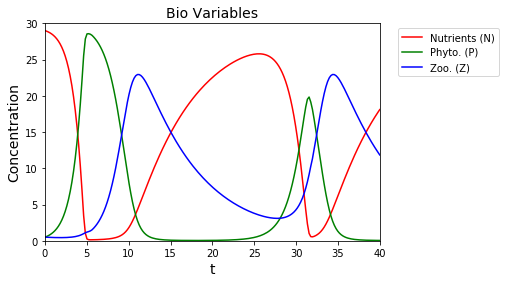

In [7]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Variables', fontsize=14)
ax_x1.set_xlabel('t', fontsize=14)
ax_x1.set_ylabel('Concentration', fontsize=14)
ax_x1.plot(t.numpy(), x_npz[:, 0, 0], '-r', label = 'Nutrients (N)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 1], '-g', label = 'Phyto. (P)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 2], '-b', label = 'Zoo. (Z)')
ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left")


## NNPZD Model

In [8]:
app = bio.bio_eqn_args(T = 40., nt = 200, z = -15, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, K_u = 1., Psi = 1.46,
                    Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, Phi = 0.175, Omega = 0.041, T_bio = 30., bio_model = 'NNPZD')

x0 = initial_cond(app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

In [9]:
x_nnpzd = ddeinttf(bio.bio_eqn(app), x0, t)

/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


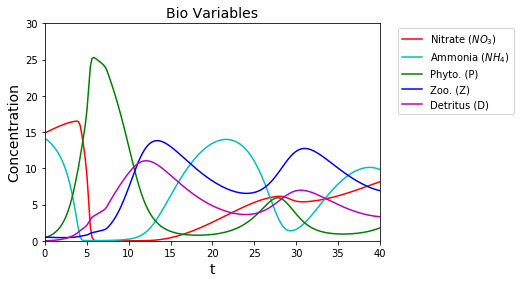

In [10]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Variables', fontsize=14)
ax_x1.set_xlabel('t', fontsize=14)
ax_x1.set_ylabel('Concentration', fontsize=14)
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 0], '-r', label = 'Nitrate ($NO_3$)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 1], '-c', label = 'Ammonia ($NH_4$)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 2], '-g', label = 'Phyto. (P)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 3], '-b', label = 'Zoo. (Z)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 4], '-m', label = 'Detritus (D)')
ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

## Plot and compare aggregated variables

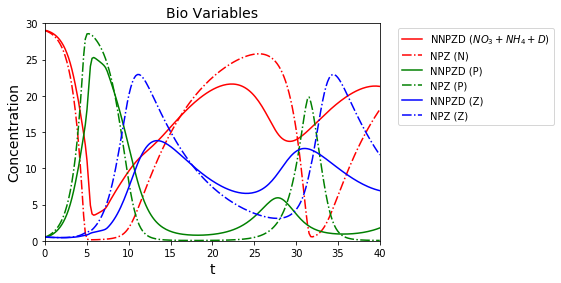

In [13]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Variables', fontsize=14)
ax_x1.set_xlabel('t', fontsize=14)
ax_x1.set_ylabel('Concentration', fontsize=14)
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 0] + x_nnpzd[:, 0, 1] + x_nnpzd[:, 0, 4], '-r', label = 'NNPZD ($NO_3 + NH_4 + D$)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 0], '-.r', label = 'NPZ (N)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 2], '-g', label = 'NNPZD (P)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 1], '-.g', label = 'NPZ (P)')
ax_x1.plot(t.numpy(), x_nnpzd[:, 0, 3], '-b', label = 'NNPZD (Z)')
ax_x1.plot(t.numpy(), x_npz[:, 0, 2], '-.b', label = 'NPZ (Z)')
ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(bbox_to_anchor=(1.04,1), loc="upper left")

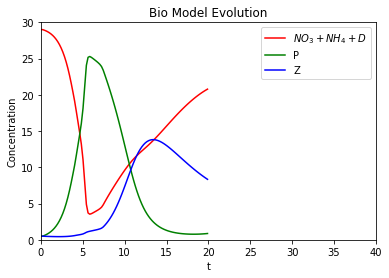

In [12]:
fig = plt.figure(figsize=(6, 4), facecolor='white')
ax_x1 = fig.add_subplot(111)

ax_x1.cla()
ax_x1.set_title('Bio Model Evolution')
ax_x1.set_xlabel('t')
ax_x1.set_ylabel('Concentration')
ax_x1.plot(t.numpy()[0:int(len(t.numpy())/2)], x_nnpzd[0:int(len(t.numpy())/2), 0, 0] + x_nnpzd[0:int(len(t.numpy())/2), 0, 1] + x_nnpzd[0:int(len(t.numpy())/2), 0, 4], '-r', label = '$NO_3 + NH_4 + D$')
ax_x1.plot(t.numpy()[0:int(len(t.numpy())/2)], x_nnpzd[0:int(len(t.numpy())/2), 0, 2], '-g', label = 'P')
ax_x1.plot(t.numpy()[0:int(len(t.numpy())/2)], x_nnpzd[0:int(len(t.numpy())/2), 0, 3], '-b', label = 'Z')
ax_x1.set_xlim(t[0], t[-1])
ax_x1.set_ylim(0., app.T_bio)
ax_x1.legend(loc="upper right")